In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
import time

### Load Data

In [3]:
# Load data from file
with open('./u.data', 'r') as file:
    lines = file.readlines()

# Parse users, items, and ratings
users = []
items = []
ratings = []
for line in lines:
    user_id, item_id, rating, _ = line.strip().split('\t')
    users.append(int(user_id))
    items.append(int(item_id))
    ratings.append(int(rating))

# Combine into a NumPy array
data = np.column_stack((users, items, ratings))


### Plot Distribution

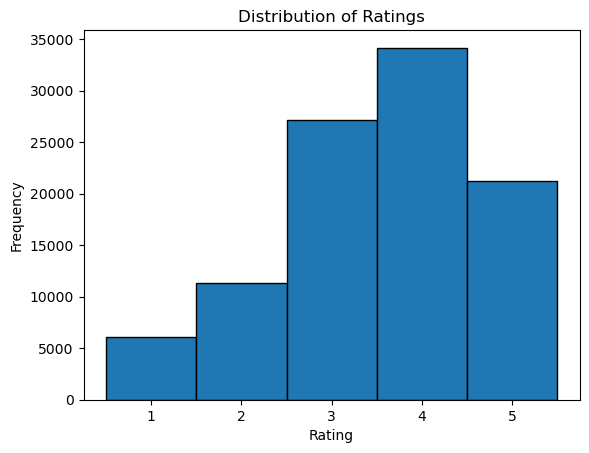

In [4]:
# Count frequency of each rating
rating_counts = Counter(ratings)
x = sorted(rating_counts.keys())
y = [rating_counts[r] for r in x]

# Plot rating distribution
plt.bar(x, y, width=1.0, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

### Split into train and test

In [5]:
# Number of users and items
n_users = np.max(data[:, 0])
n_items = np.max(data[:, 1])

# Initialize sparse matrices
data_by_user_train = lil_matrix((n_users, n_items))
data_by_user_test = lil_matrix((n_users, n_items))
data_by_movie_train = lil_matrix((n_items, n_users))
data_by_movie_test = lil_matrix((n_items, n_users))

# Initialize ratings lists
user_ratings = [[] for _ in range(n_users + 1)]
item_ratings = [[] for _ in range(n_items + 1)]

# Populate user and item ratings
for u, i, r in data:
    user_ratings[int(u)].append((int(i), float(r)))
    item_ratings[int(i)].append((int(u), float(r)))

# Split into train and test
train_data = []
test_data = []

for u in range(1, n_users + 1):
    ratings = user_ratings[u]
    if len(ratings) == 0:
        continue
    elif len(ratings) == 1:
        train_data.append((u, ratings[0][0], ratings[0][1]))
        continue

    train_split, test_split = train_test_split(
        ratings, test_size=0.2, random_state=99
    )

    for i, r in train_split:
        train_data.append((u, i, r))
    for i, r in test_split:
        test_data.append((u, i, r))

train_data = np.array(train_data)
test_data = np.array(test_data)

# Re-initialize user and item ratings for training
user_ratings = [[] for _ in range(n_users + 1)]
item_ratings = [[] for _ in range(n_items + 1)]

# Fill training matrices and lists
for u, i, r in train_data:
    data_by_user_train[int(u) - 1, int(i) - 1] = r
    user_ratings[int(u)].append((int(i), float(r)))
    item_ratings[int(i)].append((int(u), float(r)))

# Fill test matrices
for u, i, r in test_data:
    data_by_user_test[int(u) - 1, int(i) - 1] = r

# Transpose to get movie-by-user matrices
data_by_movie_train = data_by_user_train.transpose().tocsr()
data_by_movie_test = data_by_user_test.transpose().tocsr()

# Mean rating in training data
mu_train = np.mean(train_data[:, 2])

In [6]:
# Convert test data to COO format if not already
test_data = data_by_user_test.tocoo()

# Trivial RMSE: predict global mean for all test entries
trivial_sq_err = 0
n_test = 0

for user, item, r in zip(test_data.row, test_data.col, test_data.data):
    pred = mu_train  # global mean
    trivial_sq_err += (r - pred) ** 2
    n_test += 1

trivial_rmse = np.sqrt(trivial_sq_err / n_test)
print(f"Trivial RMSE (predicting global mean) = {trivial_rmse:.4f}")


Trivial RMSE (predicting global mean) = 1.1267


### Implement alternating least squares (bias only)

$$
\boxed{
b_m^{(u)} = \frac{\lambda \sum_{n \in \Omega(m)\left(r_{mn}-b_n^{(i)}\right)}}{\lambda |\Omega (m)| + \gamma}
}
$$

$$
\boxed{
b_n^{(i)} = \frac{\lambda \sum_{m \in \Omega(n)\left(r_{mn}-b_m^{(u)}\right)}}{\lambda |\Omega (n)| + \gamma}
}
$$


In [ ]:
# Hyperparameters
lam = 0.05
gamma = 0.05
max_iter = 20

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# History tracking
nll_history = []
train_rmse_history = []
test_rmse_history = []


for iteration in range(max_iter):
    # --- Update user biases ---
    for user in range(1, n_users + 1):
        rated = user_ratings[user]
        bias_sum = 0
        n_rated = 0
        for item, r in rated:
            bias_sum += r - item_bias[item - 1] - mu_train
            n_rated += 1
        user_bias[user - 1] = lam * bias_sum / (lam * n_rated + gamma)

    # --- Update item biases ---
    for item in range(1, n_items + 1):
        rated = item_ratings[item]
        bias_sum = 0
        n_rated = 0
        for user, r in rated:
            bias_sum += r - user_bias[user - 1] - mu_train
            n_rated += 1
        item_bias[item - 1] = lam * bias_sum / (lam * n_rated + gamma)

    # --- Compute negative log-likelihood (NLL) ---
    squared_error = 0
    for user in range(1, n_users + 1):
        for item, r in user_ratings[user]:
            pred = user_bias[user - 1] + item_bias[item - 1] + mu_train
            squared_error += (r - pred) ** 2

    reg_user = np.sum(user_bias ** 2)
    reg_item = np.sum(item_bias ** 2)
    nll = (lam / 2) * squared_error + (gamma / 2) * (reg_user + reg_item)
    nll_history.append(nll)

    # --- Compute training RMSE ---
    train_sq_err = 0
    n_train = 0
    for user in range(1, n_users + 1):
        for item, r in user_ratings[user]:
            pred = user_bias[user - 1] + item_bias[item - 1] + mu_train
            train_sq_err += (r - pred) ** 2
            n_train += 1
    train_rmse = np.sqrt(train_sq_err / n_train)
    train_rmse_history.append(train_rmse)

    # --- Compute test RMSE ---
    test_sq_err = 0
    n_test = 0
    test_data = data_by_user_test.tocoo()
    for user, item, r in zip(test_data.row, test_data.col, test_data.data):
        pred = user_bias[user] + item_bias[item] + mu_train
        test_sq_err += (r - pred) ** 2
        n_test += 1
    test_rmse = np.sqrt(test_sq_err / n_test)
    test_rmse_history.append(test_rmse)

    # Print progress every 2 iterations
    if (iteration + 1) % 2 == 0:
        print(
            f"Iteration {iteration + 1}, "
            f"NLL = {nll:.4f}, "
            f"Train RMSE = {train_rmse:.4f}, "
            f"Test RMSE = {test_rmse:.4f}"
        )

Iteration 2, NLL = 1682.2395, Train RMSE = 0.9142, Test RMSE = 0.9340
Iteration 4, NLL = 1678.8834, Train RMSE = 0.9131, Test RMSE = 0.9328
Iteration 6, NLL = 1678.6299, Train RMSE = 0.9131, Test RMSE = 0.9327
Iteration 8, NLL = 1678.4289, Train RMSE = 0.9130, Test RMSE = 0.9327
Iteration 10, NLL = 1678.2512, Train RMSE = 0.9130, Test RMSE = 0.9326
Iteration 12, NLL = 1678.0936, Train RMSE = 0.9130, Test RMSE = 0.9326
Iteration 14, NLL = 1677.9539, Train RMSE = 0.9130, Test RMSE = 0.9326
Iteration 16, NLL = 1677.8301, Train RMSE = 0.9130, Test RMSE = 0.9326
Iteration 18, NLL = 1677.7203, Train RMSE = 0.9130, Test RMSE = 0.9326
Iteration 20, NLL = 1677.6229, Train RMSE = 0.9130, Test RMSE = 0.9326


### Negative log likelihood, train and test RMSE

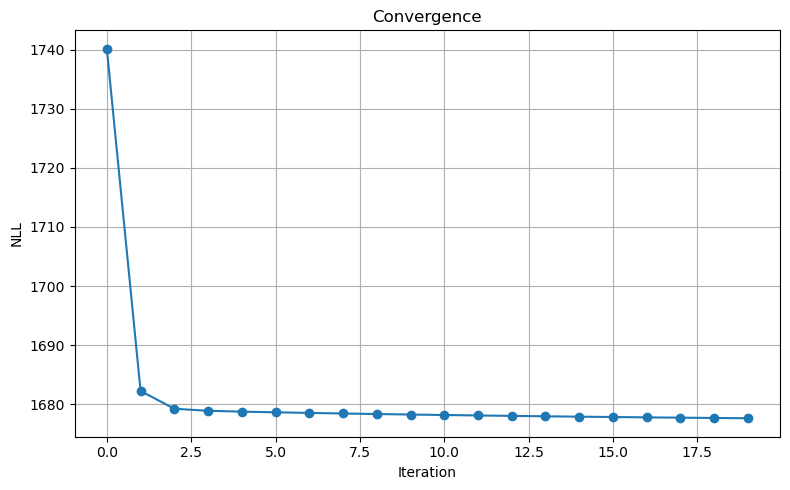

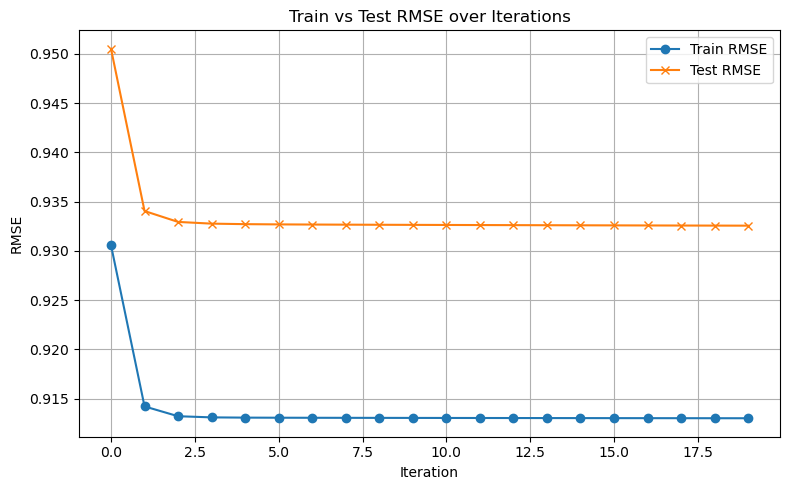

In [8]:
# Plot NLL convergence
plt.figure(figsize=(8, 5))
plt.plot(nll_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('NLL')
plt.title('Convergence')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train vs Test RMSE
plt.figure(figsize=(8, 5))
plt.plot(train_rmse_history, label='Train RMSE', marker='o')
plt.plot(test_rmse_history, label='Test RMSE', marker='x')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE over Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Implement alternating least squares

$$
\boxed{
b_m^{(u)} = \frac{\lambda \sum_{n \in \Omega(m)\left(r_{mn}-(\mathbf{u}_m^T \mathbf{v}_n + b_n^{(i)})\right)}}{\lambda |\Omega (m)| + \gamma}
}
$$

$$
\boxed{
b_n^{(i)} = \frac{\lambda \sum_{m \in \Omega(n)\left(r_{mn}-(\mathbf{u}_m^T \mathbf{v}_n + b_m^{(u)})\right)}}{\lambda |\Omega (n)| + \gamma}
}
$$



$$
\boxed{
\mathbf{u}_m = \left(\lambda \sum_{n} \mathbf{v}_n \mathbf{v}_n^T +\tau \mathbf{I}\right)^{-1} \left(\lambda \sum_{n}\mathbf{v}_n (r_{mn} - b_m^{(u)} - b_n^{(i)}) \right)
}
$$

$$
\boxed{
\mathbf{v}_n = \left(\lambda \sum_{m} \mathbf{u}_m \mathbf{u}_m^T +\tau \mathbf{I}\right)^{-1} \left(\lambda \sum_{m}\mathbf{u}_m (r_{mn} - b_m^{(u)} - b_n^{(i)}) \right)
}
$$


In [ ]:
# Hyperparameters
lam = 0.017684422019387584
gamma = 0.06224262766516858
tau = 0.29037492246228525
k = 15
max_iter = 25

# Initialize biases and embeddings
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)
user_embedding = np.random.normal(scale=0.1, size=(n_users, k))
item_embedding = np.random.normal(scale=0.1, size=(n_items, k))

# History tracking
nll_history = []
train_rmse_history = []
test_rmse_history = []

for iteration in range(max_iter):
    # --- Update user biases and embeddings ---
    for user in range(1, n_users + 1):
        rated = user_ratings[user]
        bias_sum = 0
        n_rated = 0

        items = []
        ratings_list = []

        # Compute user bias
        for item, r in rated:
            items.append(item - 1)
            ratings_list.append(r)
            pred = user_embedding[user - 1].T @ item_embedding[item - 1] + item_bias[item - 1] + mu_train
            bias_sum += r - pred
            n_rated += 1
        user_bias[user - 1] = lam * bias_sum / (lam * n_rated + gamma)

        # Update user embedding
        sum1 = item_embedding[items].T @ item_embedding[items]
        sum2 = item_embedding[items].T @ (np.array(ratings_list) - user_bias[user - 1] - item_bias[items] - mu_train)
        p1 = lam * sum1 + tau * np.eye(k)
        p2 = lam * sum2
        user_embedding[user - 1] = np.linalg.solve(p1, p2)

    # --- Update item biases and embeddings ---
    for item in range(1, n_items + 1):
        rated = item_ratings[item]
        bias_sum = 0
        n_rated = 0

        users_list = []
        ratings_list = []

        # Compute item bias
        for user, r in rated:
            users_list.append(user - 1)
            ratings_list.append(r)
            pred = item_embedding[item - 1].T @ user_embedding[user - 1] + user_bias[user - 1] + mu_train
            bias_sum += r - pred
            n_rated += 1
        item_bias[item - 1] = lam * bias_sum / (lam * n_rated + gamma)

        # Update item embedding
        sum1 = user_embedding[users_list].T @ user_embedding[users_list]
        sum2 = user_embedding[users_list].T @ (np.array(ratings_list) - item_bias[item - 1] - user_bias[users_list] - mu_train)
        p1 = lam * sum1 + tau * np.eye(k)
        p2 = lam * sum2
        item_embedding[item - 1] = np.linalg.solve(p1, p2)

    # --- Compute negative log-likelihood (NLL) ---
    squared_error = 0
    for user in range(1, n_users + 1):
        for item, r in user_ratings[user]:
            pred = user_embedding[user - 1].T @ item_embedding[item - 1] + user_bias[user - 1] + item_bias[item - 1] + mu_train
            squared_error += (r - pred) ** 2

    reg_user_bias = np.sum(user_bias ** 2)
    reg_item_bias = np.sum(item_bias ** 2)
    reg_user_embedding = np.sum(user_embedding ** 2)
    reg_item_embedding = np.sum(item_embedding ** 2)

    nll = (lam / 2) * squared_error + \
          (gamma / 2) * (reg_user_bias + reg_item_bias) + \
          (tau / 2) * (reg_user_embedding + reg_item_embedding)
    nll_history.append(nll)

    # --- Compute training RMSE ---
    train_sq_err = 0
    n_train = 0
    for user in range(1, n_users + 1):
        for item, r in user_ratings[user]:
            pred = user_embedding[user - 1].T @ item_embedding[item - 1] + user_bias[user - 1] + item_bias[item - 1] + mu_train
            train_sq_err += (r - pred) ** 2
            n_train += 1
    train_rmse = np.sqrt(train_sq_err / n_train)
    train_rmse_history.append(train_rmse)

    # --- Compute test RMSE ---
    test_sq_err = 0
    n_test = 0
    test_data = data_by_user_test.tocoo()
    for user, item, r in zip(test_data.row, test_data.col, test_data.data):
        pred = user_embedding[user].T @ item_embedding[item] + user_bias[user] + item_bias[item] + mu_train
        test_sq_err += (r - pred) ** 2
        n_test += 1
    test_rmse = np.sqrt(test_sq_err / n_test)
    test_rmse_history.append(test_rmse)

    # Print progress
    print(f"Iteration {iteration + 1}, "
          f"NLL = {nll:.4f}, "
          f"Train RMSE = {train_rmse:.4f}, "
          f"Test RMSE = {test_rmse:.4f}")

Iteration 1, NLL = 626.5232, Train RMSE = 0.9237, Test RMSE = 0.9484
Iteration 2, NLL = 598.8539, Train RMSE = 0.8910, Test RMSE = 0.9264
Iteration 3, NLL = 585.9605, Train RMSE = 0.8589, Test RMSE = 0.9132
Iteration 4, NLL = 580.6726, Train RMSE = 0.8391, Test RMSE = 0.9078
Iteration 5, NLL = 578.6403, Train RMSE = 0.8287, Test RMSE = 0.9058
Iteration 6, NLL = 577.6402, Train RMSE = 0.8229, Test RMSE = 0.9051
Iteration 7, NLL = 577.0353, Train RMSE = 0.8193, Test RMSE = 0.9047
Iteration 8, NLL = 576.6392, Train RMSE = 0.8169, Test RMSE = 0.9045
Iteration 9, NLL = 576.3721, Train RMSE = 0.8155, Test RMSE = 0.9044
Iteration 10, NLL = 576.1860, Train RMSE = 0.8145, Test RMSE = 0.9043
Iteration 11, NLL = 576.0504, Train RMSE = 0.8139, Test RMSE = 0.9042
Iteration 12, NLL = 575.9474, Train RMSE = 0.8135, Test RMSE = 0.9041
Iteration 13, NLL = 575.8665, Train RMSE = 0.8132, Test RMSE = 0.9040
Iteration 14, NLL = 575.8016, Train RMSE = 0.8130, Test RMSE = 0.9039
Iteration 15, NLL = 575.7484,

### Negative log likelihood, train and test RMSE

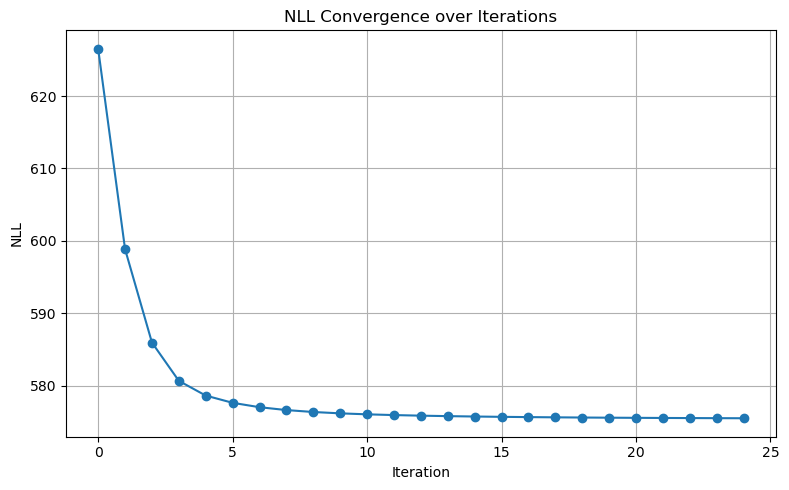

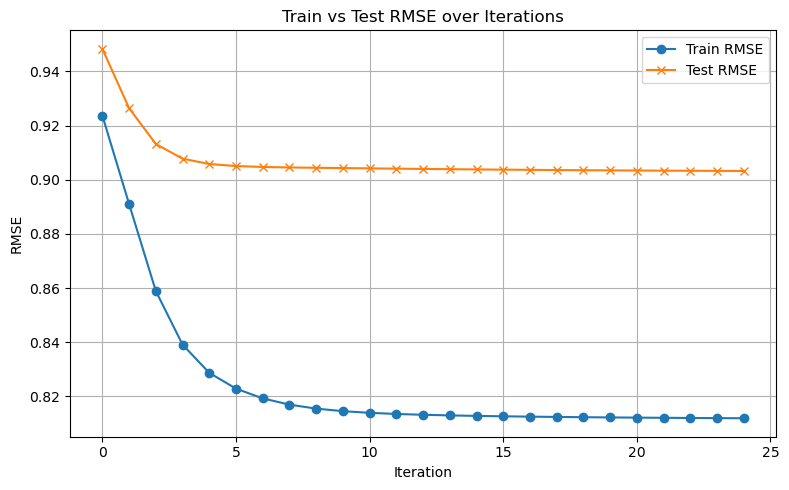

In [10]:
# --- Plot NLL convergence ---
plt.figure(figsize=(8, 5))
plt.plot(nll_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('NLL')
plt.title('NLL Convergence over Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Train vs Test RMSE ---
plt.figure(figsize=(8, 5))
plt.plot(train_rmse_history, label='Train RMSE', marker='o')
plt.plot(test_rmse_history, label='Test RMSE', marker='x')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE over Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
